# Data til mood classification


In [149]:
#importing important libraries
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import os


#Pytorch import
import torch
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import math
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow               import keras    
from torchvision              import models  
from tensorflow.keras.utils   import load_img, img_to_array
from torch.nn                 import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, LogSoftmax, ReLU
from skimage                  import io
from torch.nn.functional      import relu, elu, relu6, sigmoid, tanh, softmax
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [150]:
def loadData(dir_path, target, printProgress = True, earlyBreak = 0):
    newArr = []
    if printProgress:
        print('Files in :')
        
    for t in target:
        dir_pathTemp = dir_path + t
    
        temp = []
        for j, i in enumerate(os.listdir(dir_pathTemp)):
            if i.endswith('.jpg'):
                temp.append(io.imread(dir_pathTemp + "/" + i))
                if (earlyBreak != 0 and earlyBreak == j):
                    break
            count = j
      
        if printProgress:
            print('File count in',t,':', count)

        for tmp in temp:
            newArr.append([tmp, np.where(target == t)[0][0]])

    return np.asarray(newArr)

In [151]:
expression = np.array(['angry', 'happy', 'surprise', 'disgust', 'neutral', 'fear', 'sad'])
train_data_load = loadData("/home/dl17e22/images/train/", expression)
test_data_load  = loadData("/home/dl17e22/images/validation/", expression)

Files in :
File count in angry : 3992
File count in happy : 7163
File count in surprise : 3204
File count in disgust : 435
File count in neutral : 4981
File count in fear : 4102
File count in sad : 4937
Files in :


/tmp/ipykernel_3449136/3140478634.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(newArr)


File count in angry : 959
File count in happy : 1824
File count in surprise : 796
File count in disgust : 110
File count in neutral : 1215
File count in fear : 1017
File count in sad : 1138


In [173]:
# Shuffles training data
np.random.shuffle(train_data_load)
np.random.shuffle(test_data_load)

#Collects both datafolders in one and makes it into a panda frame
data_load = np.concatenate((train_data_load, test_data_load), axis=0)
pd_data = pd.DataFrame(data_load)
pd_data.columns = ['image','label']
print(len(data_load))

#Takes 80% to train data
df_train = pd_data.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.8))

#Removes it from the collected data
df_valid_test = pd_data.drop(df_train.index)

#Takes half of the ramining data to validation data and leaves the rest for test data
df_valid = df_valid_test.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.5))
df_test = df_valid_test.drop(df_valid.index)

#Back to Numpy arrays
train_data = df_train.to_numpy()
valid_data = df_valid.to_numpy()
test_data = df_test.to_numpy()
print('Number of images in Train: ',train_data.shape[0])
print('Number of images in Valid: ',valid_data.shape[0])
print('Number of images in Test: ',test_data.shape[0])

#Function that makes correct dimensions
def correctFormat(arr):
    newArr = []
    for i, x in enumerate(arr):
        newArr.append(np.expand_dims(x, axis = 0).astype('float32'))
    return np.asarray(newArr)


# Splitting data to an array with images and an array of target emotion
# Training Data
x_train      = correctFormat(train_data[:,0])
train_target = np.asarray(train_data[:,1]).astype('int8')

# Validation Data
x_valid      = correctFormat(valid_data[:,0])
valid_target = np.asarray(valid_data[:, 1]).astype('int8')

# Test Data
x_test      = correctFormat(test_data[:,0])
test_target = test_data[:, 1]

35887
Number of images in Train:  28710
Number of images in Valid:  3589
Number of images in Test:  3588


In [163]:
no_of_classes = 7

from torch.nn.modules.batchnorm import BatchNorm2d
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1     = nn.Conv2d(in_channels = 1,   out_channels = 64,  kernel_size = 3, padding = 'same')
        self.conv2     = nn.Conv2d(in_channels = 64,  out_channels = 128, kernel_size = 5, padding = 'same')
        self.conv3     = nn.Conv2d(in_channels = 128, out_channels = 512, kernel_size = 3, padding = 'same')
        self.conv4     = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 'same')
        self.batch2d_1 = nn.BatchNorm2d(64)
        self.batch2d_2 = nn.BatchNorm2d(128)
        self.batch2d_3 = nn.BatchNorm2d(512)

        self.batch2d_4 = nn.BatchNorm1d(256)
        self.batch2d_5 = nn.BatchNorm1d(512)
        self.pool      = nn.MaxPool2d(kernel_size = 2)
        self.dropout   = nn.Dropout(0.10)
        self.flatten   = nn.Flatten()

        self.relu     = nn.ReLU()
        self.FC1      = nn.Linear(4608, 256)
        self.log_softmax  = nn.LogSoftmax(dim = 1)
        self.FC2      = nn.Linear(256, 512)
        self.FC3      = nn.Linear(512, 7)
    

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.batch2d_1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.pool(x)
        x = self.batch2d_2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.pool(x)
        x = self.batch2d_3(x)
        x = F.relu(x)
        x = self.dropout(x) 

        x = self.conv4(x)
        x = self.pool(x)
        x = self.batch2d_3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.FC1(x)
        x = self.batch2d_4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.FC2(x)
        x = self.batch2d_5(x)
        x = F.relu(x)
        x = self.dropout(x)
                        
        x = self.FC3(x)
        x = self.log_softmax(x)
        
        return x

net = NeuralNetwork()
print(net)

NeuralNetwork(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch2d_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2d_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2d_3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2d_4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2d_5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (FC1): Li

In [164]:
#The choosen optimizer is the Adam optimizer
loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.2, patience = 2, verbose = True)

In [ ]:
x = np.random.randn(2, 1, 48,48).astype('float32')
out = net(torch.from_numpy(x_train[0:2]))
print('Output shape:', out.shape)
print('Output tensor:')
print(np.asarray(torch.max(out,1)[1]))
print(out)

In [ ]:
print_output = []

batch_size = 128
num_epochs = 40

num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc,  test_loss  = [], []

cur_loss = 0


def get_slice(i, size):
    return range(i * size, (i + 1) * size)

def accuracy_score(targets, predictions):
    return 1.0 * np.sum((np.array(targets) == np.array(predictions)))/len(targets)

# This function iterates through all batches of a dataset, X_data and returns predictions and matching targets
def evaluateLoop(X_data, targets, num_batches):
    allTargets, allPredictions = [], []
    
    # Iterate through the batches
    for i in range(num_batches):
        slce    = get_slice(i, batch_size)
        x_batch = torch.from_numpy(X_data[slce])
        
        output      = net(x_batch)
        predictions = torch.max(output, 1)[1]
        
        allTargets     += list(targets[slce])
        allPredictions += list(predictions.data.numpy())             
    
    return allTargets, allPredictions


for epoch in range(num_epochs):
    st_epoch = time.time()
    # Train
    losses = []
    loss = 0
    loss_valid = 0
    np.random.shuffle(train_data)
    np.random.shuffle(valid_data)

    # Splitting data to an array with images and an array of target emotion
    # Training Data
    x_train      = correctFormat(train_data[:,0])
    train_target = np.asarray(train_data[:,1]).astype('int8')

    # Validation Data
    x_valid      = correctFormat(valid_data[:,0])
    valid_target = np.asarray(valid_data[:, 1]).astype('int8')

    net.train()
    for i in range(num_batches_train):
        slce    = get_slice(i, batch_size)
        x_batch = torch.from_numpy(x_train[slce])
        output  = net(x_batch) # Forward pass
        
        # Compute gradients given loss
        target_batch = torch.from_numpy(train_target[slce]).long()
        batch_loss   = loss_fn(output, target_batch) # Calculate loss
        batch_loss.backward() # Backpropagation
        
        loss += batch_loss.item()
        
        
        optimizer.step()      # Update parameters
        optimizer.zero_grad() # Reset gradients
            
    net.eval()    
    for i in range(num_batches_valid):
        slce    = get_slice(i, batch_size)
        x_batch = torch.from_numpy(x_valid[slce])
        output  = net(x_batch) # Forward pass
        
        # Compute gradients given loss
        target_batch = torch.from_numpy(valid_target[slce]).long()
        batch_loss   = loss_fn(output, target_batch) # Calculate loss
        
        loss_valid += batch_loss.item()
        
       
        
    loss = loss / num_batches_train 
    loss_valid = loss_valid /num_batches_valid
    train_loss.append(loss)   
    valid_loss.append(loss_valid)
    
    net.train()
    scheduler.step(loss_valid)
    net.eval()
    
    
    # Evaluate training data 
    train_targs, train_preds = evaluateLoop(X_data = x_train, targets = train_target, num_batches = num_batches_train)
    
    # Evaluate validation data
    val_targs, val_preds     = evaluateLoop(X_data = x_valid, targets = valid_target, num_batches = num_batches_valid)
    

    
    # Calculate accuracies
    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    #record end time
    et_epoch = time.time()
    
    #Save network
    train_acc_print = str(round(train_acc_cur,2)).replace('.','')
    path = '/home/dl17e22/NETS/bestoriginal/net-epoch '+str(epoch)+'-acc '+train_acc_print+'.pth'
    torch.save(net.state_dict(), path)
    
    #Plot output
    time_e = et_epoch-st_epoch
    minutes = time_e //60
    seconds = time_e % 60
    
    print_output.append([epoch + 1,minutes,seconds, train_loss[-1], valid_loss[-1], train_acc_cur, valid_acc_cur])
    print()
    print("Epoch %2i - %2i min. %2i sec. : Train Loss %.3f, Valid Loss %.3f, Train acc %.3f, Valid acc %.3f" % (epoch + 1,minutes,seconds, train_loss[-1], valid_loss[-1], train_acc_cur, valid_acc_cur))
        
# Evaluate test set
x_batch = torch.from_numpy(x_test)
output  = net(x_batch)
preds   = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(test_target), list(preds.data.numpy()))))

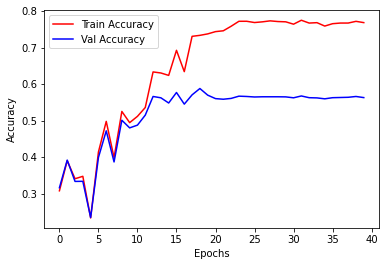

In [169]:
# Plot training and validation accuracies vs. epochs
epoch = range(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r'
, epoch, valid_acc, 'b')
plt.legend(['Train Accuracy'
, 'Val Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

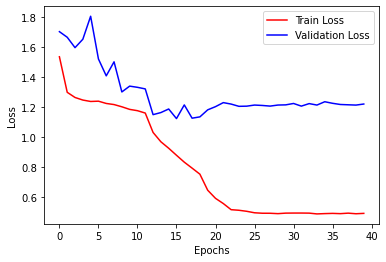

In [ ]:
#Plot training and validation loss vs. epochs
epoch = range(len(train_acc))
plt.figure()
plt.plot(epoch, train_loss, 'r'
, epoch, valid_loss, 'b')
plt.legend(['Train Loss'
, 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()